# Weld Path - Dynamic Programming

## 1. Problem Description

The design of an automatic weld follower involves tracking the joint. This can be achieved by projecting a laser line and using a camera positioned at a different angle. This way, different positions of the laser line in the image correspond to different heights.

[Picture of laser line+camera]

Identifying the laser line may not be a trivial task because the image may contain artifacts like:

- Reflections (a ghost line segment shows up);
- Speckles;
- Noise

Weld image from local repository.
Laser line image from http://answers.opencv.org/question/157002/help-extracting-a-laser-line/

In [1]:
import numpy as np
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
%matplotlib inline

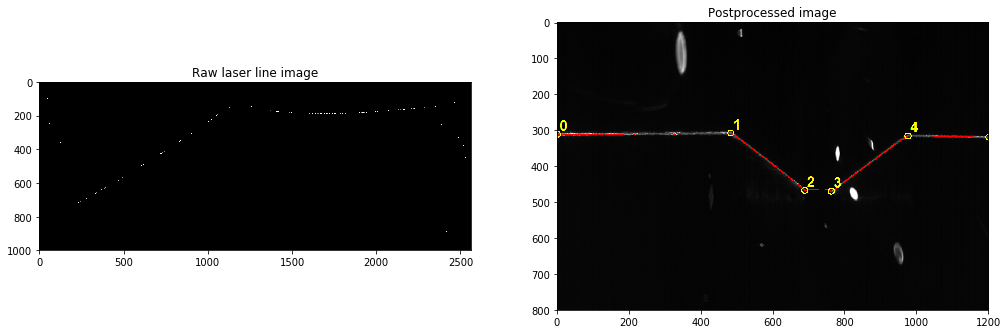

In [2]:
weldImg = np.array(Image.open('laserline.png'))
weldImgProc = np.array(Image.open('weld2proc.png'))

#display images
plt.figure(figsize=(17,17))
plt.subplot(1,2,1)
plt.title('Raw laser line image')
plt.imshow(weldImg)
plt.subplot(1,2,2)
plt.title('Postprocessed image')
plt.imshow(weldImgProc)

## 2. Keras Model

Tensor engines like TensorFlow are widely used to backpropagate gradients. Of course, they can also be used to propagate a model forward. Let's make a model that does this:

In [3]:
from keras import Model
from keras import layers as L
from keras import backend as K
from keras.engine.topology import Layer

Using TensorFlow backend.


In [4]:
def const_init(shape):
    return np.ones(shape)

class DynamicLayer(Layer):
    '''
    '''
    def __init__(self, kernel_initializer='glorot_uniform', **kwargs):
        
        #self.npixels = npixels
        self.kernel_initializer = kernel_initializer
        
        self.bigneg = -1e5
        
        super(DynamicLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.dist_weight = self.add_weight(name='dist_weight',
                                      shape=(1,),
                                      initializer=const_init, #self.kernel_initializer,
                                      trainable=True)        
        
        super(DynamicLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        '''

        '''
        #print(K.int_shape(x))
        s = K.shape(x)
        
        pad2 = self.bigneg*K.ones( (s[0],2) )
        pad1 = self.bigneg*K.ones( (s[0],1) )
        
        y0 = K.concatenate([pad2, x] )-self.dist_weight*1.4142
        y1 = K.concatenate([K.concatenate( [pad1, x]),  pad1])-self.dist_weight
        y2 = K.concatenate([x, pad2] )-self.dist_weight*1.4142
        
        y0 = K.expand_dims(y0)
        y1 = K.expand_dims(y1)
        y2 = K.expand_dims(y2)
        
        y = K.max(K.concatenate([y0,y1,y2]),-1)
        
        return y[:,1:-1]

    def compute_output_shape(self, input_shape):
        return input_shape

In [5]:
def DPModel(height, width):
    inp=L.Input( (height,width) )
    
    dplayer = DynamicLayer()
    
    xprev=L.Lambda(lambda z: z[:,:,0]) (inp) #slice a column
    
    expand_dims = L.Lambda(lambda z: K.expand_dims(z,-1))
    intx = expand_dims(xprev)
    
    temp = [0]*(width-1)
    
    for k in range(width-1):
        x=dplayer (xprev)
        
        temp=L.Lambda(lambda z: z[:,:,k+1]) (inp) #slice a column
        xprev = L.Add()([x,temp])
        
        intx = L.Concatenate() ( [intx, expand_dims(xprev)] )
    
    #this shows up too big in summary. Let us make an individual model for it
    dpmodel=Model(inputs=inp, outputs=intx, name='dpModel_{}_{}'.format(height,width))
    
    #inp2=L.Input( (height,width) )
    #intx2 = dpmodel(inp2)
    #model = Model(inputs=inp2, outputs=intx2)
    
    return dpmodel

#inp2=L.Input( (weldImg.shape[0], weldImg.shape[1]) )
#intx2 = DPModel(weldImg.shape[0], weldImg.shape[1])(inp2)
#model = Model(inputs=inp2, outputs=intx2)

model = DPModel(weldImg.shape[0], weldImg.shape[1])
#model.summary(100)

In [6]:
#sanity check
s_model = DPModel(6,4)
v = np.expand_dims(np.array([[0,0,0,2,0,0],[0,0,3,0,0,0],[0,0,5,0,0,0],[0,0,15,0,0,0]]).T,axis=0)
v=v[0:1,:,0:4]
v.shape
pred = s_model.predict(v)
print(pred)
pred.shape

[[[ 0.         -1.         -2.          0.7574004 ]
  [ 0.         -1.          2.1716003   6.1716003 ]
  [ 0.          3.5858002   7.5858     21.5858    ]
  [ 2.          1.          2.1716003   6.1716003 ]
  [ 0.          0.58580005 -0.41419995  0.7574004 ]
  [ 0.         -1.         -0.8283999  -1.8283999 ]]]


(1, 6, 4)

In [7]:
img = np.sum(weldImg[:,:,0:3], axis=2)
img = np.expand_dims(img,axis=0)
img.shape

(1, 1000, 2560)

In [8]:
%%time
imgInt = model.predict(img)

Wall time: 54.9 s


In [9]:
imgInt.shape

(1, 1000, 2560)

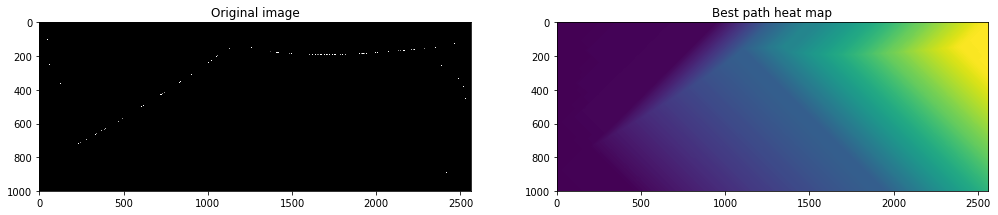

In [10]:
plt.figure(figsize=(17,17))
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(img[0], cmap='gray')
plt.subplot(1,2,2)
plt.title('Best path heat map')
plt.imshow(imgInt[0])

In [11]:
def backtrack(img):
    '''
    Does backtracking in an image value integral (in the columns)
    '''
    
    pos = np.argmax(img[:,-1])
    patht=[pos]
    for k in range(img.shape[1]-1):
        p = img.shape[1] - k - 2
        
        v0 = img[pos,p]-1
        
        v1=-1e5
        v2=-1e5
        
        if pos-1>=0:
            v1 = img[pos-1,p]-1.4142
        
        if pos+1<img.shape[0]:
            v2 = img[pos+1,p]-1.4142
        
        if v2>v0 and v2>v1:
            pos = pos+1
        elif v1>v0 and v1>v2:
            pos = pos-1
        patht.append(pos)
    
    return list(reversed(patht))

In [12]:
path_track = backtrack(imgInt[0])

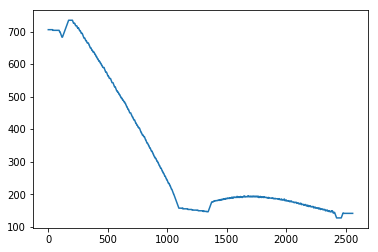

In [13]:
plt.plot(path_track)

In [14]:
imgMod=weldImg[:,:]
y=0
for x in path_track:
    #print(imgMod[y,x,:].shape)
    #if x<1000:
    imgMod[x,y,:]=[255,0,0,255]
    y+=1

In [15]:
im = Image.fromarray(imgMod)
im.save("weldProcPy.png")

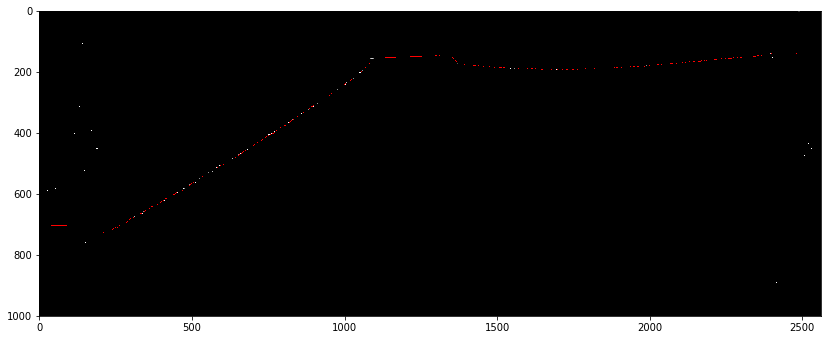

In [16]:
plt.figure(figsize=(14,14))
plt.imshow(imgMod)

In [17]:
weldImg.shape

(1000, 2560, 4)

In [18]:
model = DPModel(6,4)

In [19]:
v = np.expand_dims(np.array([[0,0,0,2,0,0],[0,0,3,0,0,0],[0,0,5,0,0,0],[0,0,15,0,0,0]]).T,axis=0)
v=v[0:1,:,0:4]
v.shape

(1, 6, 4)

In [20]:
pred = model.predict(v)
print(pred)
pred.shape

[[[ 0.         -1.         -2.          0.7574004 ]
  [ 0.         -1.          2.1716003   6.1716003 ]
  [ 0.          3.5858002   7.5858     21.5858    ]
  [ 2.          1.          2.1716003   6.1716003 ]
  [ 0.          0.58580005 -0.41419995  0.7574004 ]
  [ 0.         -1.         -0.8283999  -1.8283999 ]]]


(1, 6, 4)

In [21]:
pred = model.predict(v)
print(pred)
pred.shape

[[[ 0.         -1.         -2.          0.7574004 ]
  [ 0.         -1.          2.1716003   6.1716003 ]
  [ 0.          3.5858002   7.5858     21.5858    ]
  [ 2.          1.          2.1716003   6.1716003 ]
  [ 0.          0.58580005 -0.41419995  0.7574004 ]
  [ 0.         -1.         -0.8283999  -1.8283999 ]]]


(1, 6, 4)